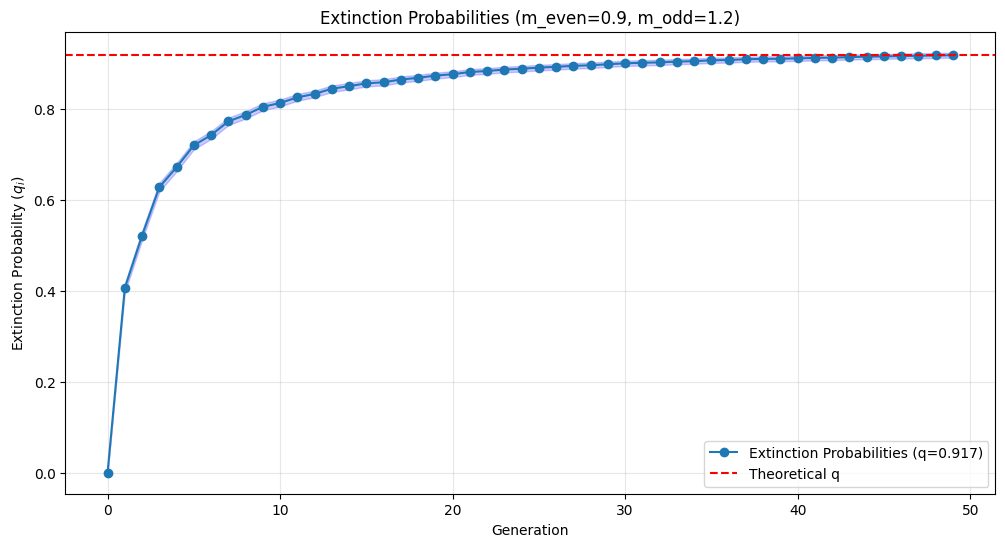

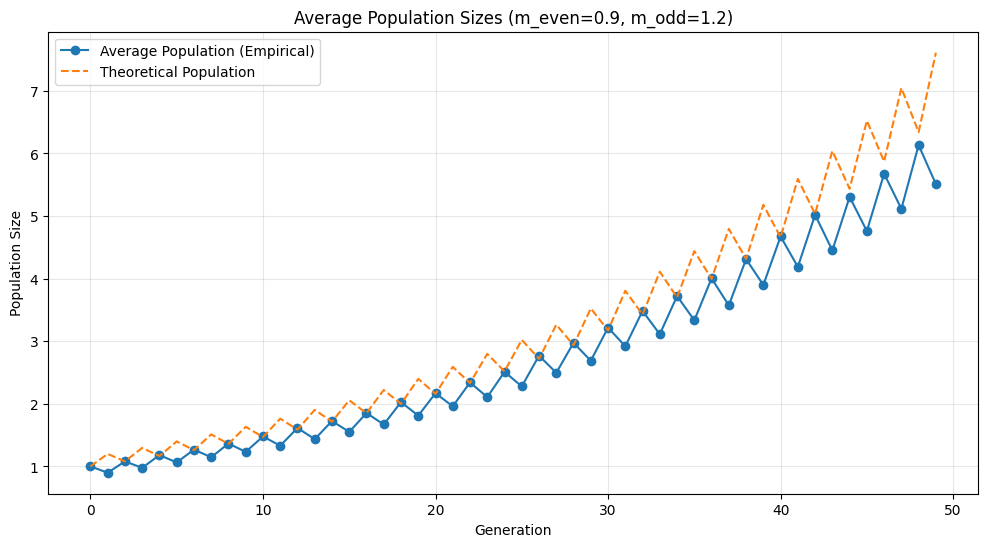

In [1]:
import numpy as np
from scipy.stats import poisson, binom, geom, norm
import matplotlib.pyplot as plt

def sample_offspring(Y_even, Y_odd, m_even, m_odd, generation):
    """
    Sample offspring based on generation parity (even or odd).
    """
    if generation % 2 == 0:  # Even generation
        if Y_even == "poisson":
            return np.random.poisson(m_even)
        elif Y_even == "binomial":
            return np.random.binomial(10, m_even / 10)
        elif Y_even == "geometric":
            return np.random.geometric(1 / m_even) - 1  # Zero-indexed
    else:  # Odd generation
        if Y_odd == "poisson":
            return np.random.poisson(m_odd)
        elif Y_odd == "binomial":
            return np.random.binomial(10, m_odd / 10)
        elif Y_odd == "geometric":
            return np.random.geometric(1 / m_odd) - 1

def galton_watson_alternating(Y_even, Y_odd, m_even, m_odd, N=10000, max_generations=50):
    """
    Simulate the Galton-Watson process with alternating distributions for extinction probabilities and population sizes.
    """
    extinction_counts = np.zeros(max_generations)
    population_sizes = np.zeros((N, max_generations))
    
    for sim in range(N):
        Z = 1  # Start with one ancestor
        for gen in range(max_generations):
            population_sizes[sim, gen] = Z
            if Z == 0:
                extinction_counts[gen:] += 1
                break
            Z = sum(sample_offspring(Y_even, Y_odd, m_even, m_odd, gen) for _ in range(int(Z)))
    
    # Estimate q_i and q
    qi = extinction_counts / N
    q = qi[-1]
    
    # Compute confidence intervals
    z = norm.ppf(0.975)  # 95% CI
    ci = [
        (q_gen - z * np.sqrt(q_gen * (1 - q_gen) / N),
         q_gen + z * np.sqrt(q_gen * (1 - q_gen) / N)) 
        for q_gen in qi
    ]
    
    return qi, q, ci, population_sizes

def plot_extinction_and_population(Y_even, Y_odd, m_even, m_odd, N=10000, max_generations=50):
    """
    Plot extinction probabilities and average population sizes for alternating distributions.
    """
    # Run simulation
    qi, q, ci, population_sizes = galton_watson_alternating(Y_even, Y_odd, m_even, m_odd, N, max_generations)
    generations = np.arange(max_generations)
    
    # Plot extinction probabilities
    plt.figure(figsize=(12, 6))
    plt.plot(generations, qi, '-o', label=f"Extinction Probabilities (q={q:.3f})")
    lower_ci = [c[0] for c in ci]
    upper_ci = [c[1] for c in ci]
    plt.fill_between(generations, lower_ci, upper_ci, color='blue', alpha=0.2)
    plt.axhline(y=q, color='red', linestyle='--', label="Theoretical q")
    plt.title(f"Extinction Probabilities (m_even={m_even}, m_odd={m_odd})")
    plt.xlabel("Generation")
    plt.ylabel("Extinction Probability ($q_i$)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Plot average population sizes
    avg_population = np.mean(population_sizes, axis=0)
    theoretical_population = [m_even ** (gen // 2) * m_odd ** ((gen + 1) // 2) for gen in generations]
    
    plt.figure(figsize=(12, 6))
    plt.plot(generations, avg_population, '-o', label="Average Population (Empirical)")
    plt.plot(generations, theoretical_population, '--', label="Theoretical Population")
    plt.title(f"Average Population Sizes (m_even={m_even}, m_odd={m_odd})")
    plt.xlabel("Generation")
    plt.ylabel("Population Size")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
Y_even = "poisson"
Y_odd = "binomial"
m_even = 0.9  # Mean offspring for even generations
m_odd = 1.2  # Mean offspring for odd generations
N = 10000  # Number of simulations
max_generations = 50  # Maximum generations

plot_extinction_and_population(Y_even, Y_odd, m_even, m_odd, N, max_generations)
